In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics
from dataloader.animal_faces import AnimalfaceDataset

%reload_ext autoreload
%autoreload 2

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
width = 128
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
# train_transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_data = AnimalfaceDataset(transform=train_transform, img_width=width)

  0%|                                                                                                                               | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████

In [7]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 137.44it/s]


In [8]:
def show_img(x):
    plt.figure(figsize=(2,2))
    plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

torch.Size([512, 3, 128, 128]) torch.Size([512])


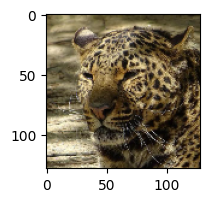

In [9]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

In [249]:
# from models.vae import VAE, Encoder, Decoder
from models.vae2 import VAE, Encoder, Decoder

%reload_ext autoreload
%autoreload 2

In [230]:
n_samples = 4
feature_size = 256
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0


if return_only_liner:
    conv_ip_size = (3, 128, 128)
    hidden_sizes = [128*128*3, 4096, feature_size]
else:
    conv_ip_size = (256,2,2)
#     hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], 256*3, 256, feature_size]
    hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]    

In [231]:
e = Encoder(filters=filters, 
            kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hidden_sizes, 
            return_only_liner=return_only_liner, return_only_conv=0, paddings=paddings, curr_device="cpu")
# op, mu, logvar = e(x.to(device)).to(device)
op, mu, logvar = e(x)
print(op.shape)
# summary(e, (3,64,64), device="cpu")
summary(e, (3,width,width), device="cpu")

torch.Size([5, 512, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             784
              ReLU-2           [-1, 16, 63, 63]               0
            Conv2d-3           [-1, 32, 30, 30]           8,224
              ReLU-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7            [-1, 128, 6, 6]         131,200
              ReLU-8            [-1, 128, 6, 6]               0
            Conv2d-9            [-1, 256, 2, 2]         524,544
             ReLU-10            [-1, 256, 2, 2]               0
          Dropout-11                 [-1, 1024]               0
           Linear-12                  [-1, 128]         131,200
Total params: 828,784
Trainable params: 828,784
Non-trainable params: 0
------

In [232]:
# d = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
#                                kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
#                                  paddings=paddings[::-1], hiddens_sizes=hidden_sizes[::-1] , return_only_conv=True)
# do = d(op.flatten(start_dim=1))
# print("hello-",do.shape)
# # summary(d, (feature_size,), device="cpu")
# summary(d, op.flatten(start_dim=1).shape, device="cpu")

In [233]:
vae = VAE(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, 
          droput_prob=dropout_prob, n_samples=n_samples).to(device)
op, enc, mu, logvar = vae(x.to(device))
print(op.shape, enc.shape)

# summary(ae, (3,32,32), device="cuda")
# summary(vae, (3,width,width), device="cuda")

[64, 1024]
torch.Size([512, 3, 128, 128]) torch.Size([5, 512, 64])


In [234]:
%%time
n_epochs = 100
beta = 10
optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
losses = []
val_losses = []
for epoch in range(n_epochs):
    vae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc, mu, logvar = vae(X) # [B, feature_size]
        loss, mse_loss, kl_loss = vae.loss_fn(X, X_hat, mu, logvar, beta=beta)
        loss.backward()
        optim.step()
        tqdm_obj.set_description_str(f"Epoch: {epoch} Train Loss {loss}")
        if i%1 == 0:
            losses.append((loss.detach().to(cpu_device), mse_loss.detach().to(cpu_device), kl_loss.detach().to(cpu_device)))
    
    with torch.no_grad(): # mandatory to write
        vae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc, mu, logvar = vae(X) # [B, feature_size]
            loss, mse_loss, kl_loss = vae.loss_fn(X, X_hat, mu, logvar, beta=beta)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {loss}")
            if i%1 == 0:
                val_losses.append((loss.detach().to(cpu_device), mse_loss.detach().to(cpu_device), kl_loss.detach().to(cpu_device)))
                

Epoch: 51 Train Loss 503544.625: 100%|██████████| 29/29 [00:08<00:00,  3.54it/s] 


Epoch: 97 Train Loss 894162.375:  41%|████▏     | 12/29 [02:51<04:02, 14.26s/it]


KeyboardInterrupt: 

In [235]:
mu, torch.exp(logvar)

(tensor([[ 0.1621, -0.2568,  0.1995,  ..., -1.4942,  1.1562,  0.4474],
         [-0.5594,  1.2314,  1.2688,  ..., -1.2922, -1.2538, -0.9615],
         [ 0.5571,  0.0926,  0.1598,  ..., -0.4945, -1.2059,  0.2519],
         ...,
         [ 0.0661, -0.0837,  0.0489,  ...,  0.4116, -0.4536, -0.3646],
         [ 0.2344, -0.6195, -0.4878,  ...,  0.2829, -0.6388,  0.1389],
         [ 0.2342, -0.0879,  0.0383,  ...,  0.1701, -0.8140, -0.2626]],
        device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[0.6494, 0.6105, 0.3871,  ..., 0.5992, 0.3772, 0.7805],
         [0.4816, 0.5273, 0.4718,  ..., 0.5844, 0.3202, 0.7479],
         [0.7252, 0.6957, 0.5422,  ..., 0.6529, 0.5356, 0.7755],
         ...,
         [0.8191, 0.7975, 0.7237,  ..., 0.7387, 0.5455, 0.8789],
         [0.7453, 0.7013, 0.5929,  ..., 0.7452, 0.5484, 0.9199],
         [0.7417, 0.8019, 0.7042,  ..., 0.7584, 0.5772, 0.8624]],
        device='cuda:0', grad_fn=<ExpBackward0>))

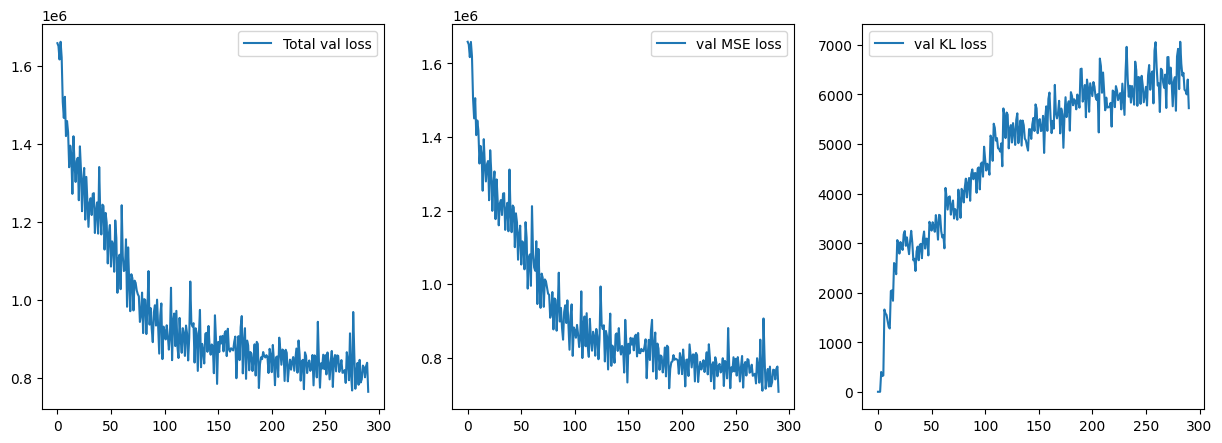

In [257]:
import numpy as np
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
model_name = f"vae_{feature_size}_1l_{beta}_{n_samples}"

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
ax1.plot(np.array(val_losses)[:,0][0:], label="Total val loss")
ax1.legend()

ax2.plot(np.array(val_losses)[:,1][0:], label="val MSE loss")
ax2.legend()

ax3.plot(np.array(val_losses)[:,2][0:], label="val KL loss")
ax3.legend()

plt.savefig("losses_" + model_name)

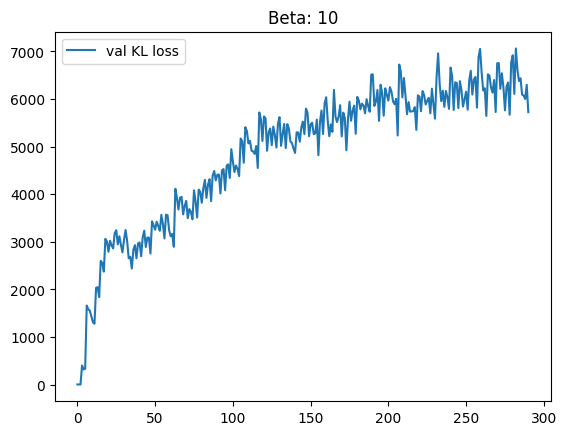

In [237]:

plt.title(f"Beta: {beta}")
# plt.plot(np.array(val_losses)[:,0][0:], label="val loss")
# plt.plot(np.array(val_losses)[:,1][0:], label="val MSE loss")
plt.plot(np.array(val_losses)[:,2][0:], label="val KL loss")

plt.legend()

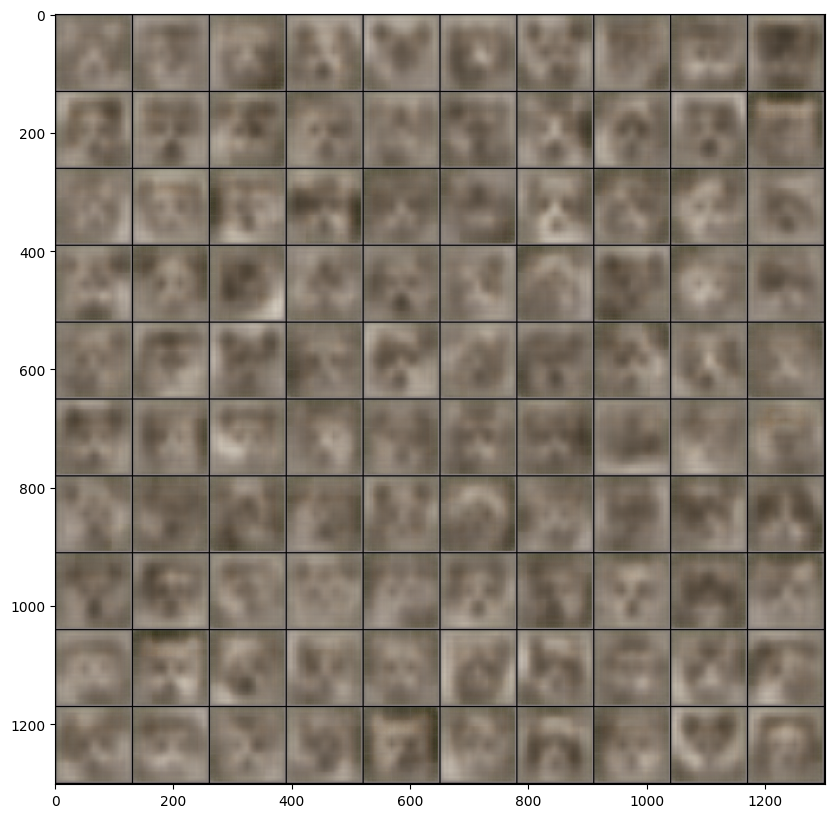

In [246]:
latents = torch.randn((n_samples, 10*10, feature_size))
x_hat = vae.decoder(latents.to(device)).mean(dim=0)
generated_grid = make_grid(x_hat, nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(generated_grid.permute(1,2,0).detach().to(cpu_device).numpy())
save_image(generated_grid,f"images/vae_generated_{feature_size}_1l_{beta}_{n_samples}.png")

In [245]:
x_hat.shape

torch.Size([4, 100, 3, 128, 128])

In [247]:
from torchvision.utils import save_image, make_grid
# Generation
grid_size = 10
# z = torch.rand(grid_size*grid_size, Z_DIM)
x_hat, enc, _, _ = vae(x.to(device))
# print(x_hat.shape) # ----> .Size([1, 3, 128, 128])
# x_hat = x_hat.squeeze() # necessary for printing image
generated_grid = make_grid(x_hat[:grid_size*grid_size], nrow=grid_size)
plt.imshow(generated_grid.permute(1,2,0).detach().to(cpu_device).numpy())
save_image(generated_grid,f"images/vae_reconstrcuted_{feature_size}_1l_{beta}.png")
# generated_grid

AttributeError: 'VAE' object has no attribute 'encoder_vae'

In [194]:
generated_grid.permute(1,2,0).shape

torch.Size([1302, 1302, 3])

In [213]:
torch.save(vae.state_dict(), f"ckpts/vae_{feature_size}_1l_{beta}.pt")

In [160]:
x, y = next(iter(val_loader))

torch.Size([512, 3, 128, 128])

<Figure size 640x480 with 0 Axes>

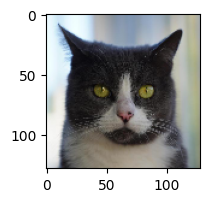

<Figure size 640x480 with 0 Axes>

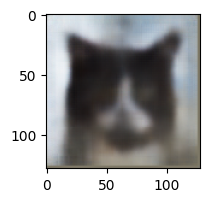

In [209]:
x, y = next(iter(val_loader))
with torch.no_grad():
    ae.eval()
    x_hat, enc = ae(x.to(device))
plt.figure()
show_img(x)
plt.figure()
show_img(x_hat)

### Observations
Effect of kernels size: 
Keep all constant (3)

effect of latent dim:
Try: 2048, 128X6X6

effect of number of filters: Looks like val loss decreasing if we increase number of filters

In [119]:
feature_size

2048

In [210]:
torch.save(ae.state_dict(), f"ckpts/autoencoder_{feature_size}_1l.pt")